<a href="https://colab.research.google.com/github/Jianhui-Li/intel-xpu-backend-for-triton/blob/llvm-target/python/tutorials/Triton_region_group.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Triton Programming

This Jupyter notebook template is based on Triton Puzzles https://github.com/srush/Triton-Puzzles

Programming for accelerators such as GPUs is critical for modern AI systems.
This often means programming directly in proprietary low-level languages such as CUDA. [Triton](https://github.com/openai/triton/) is an alternative open-source language that allows you to code at a higher-level and compile to accelerators like GPU.

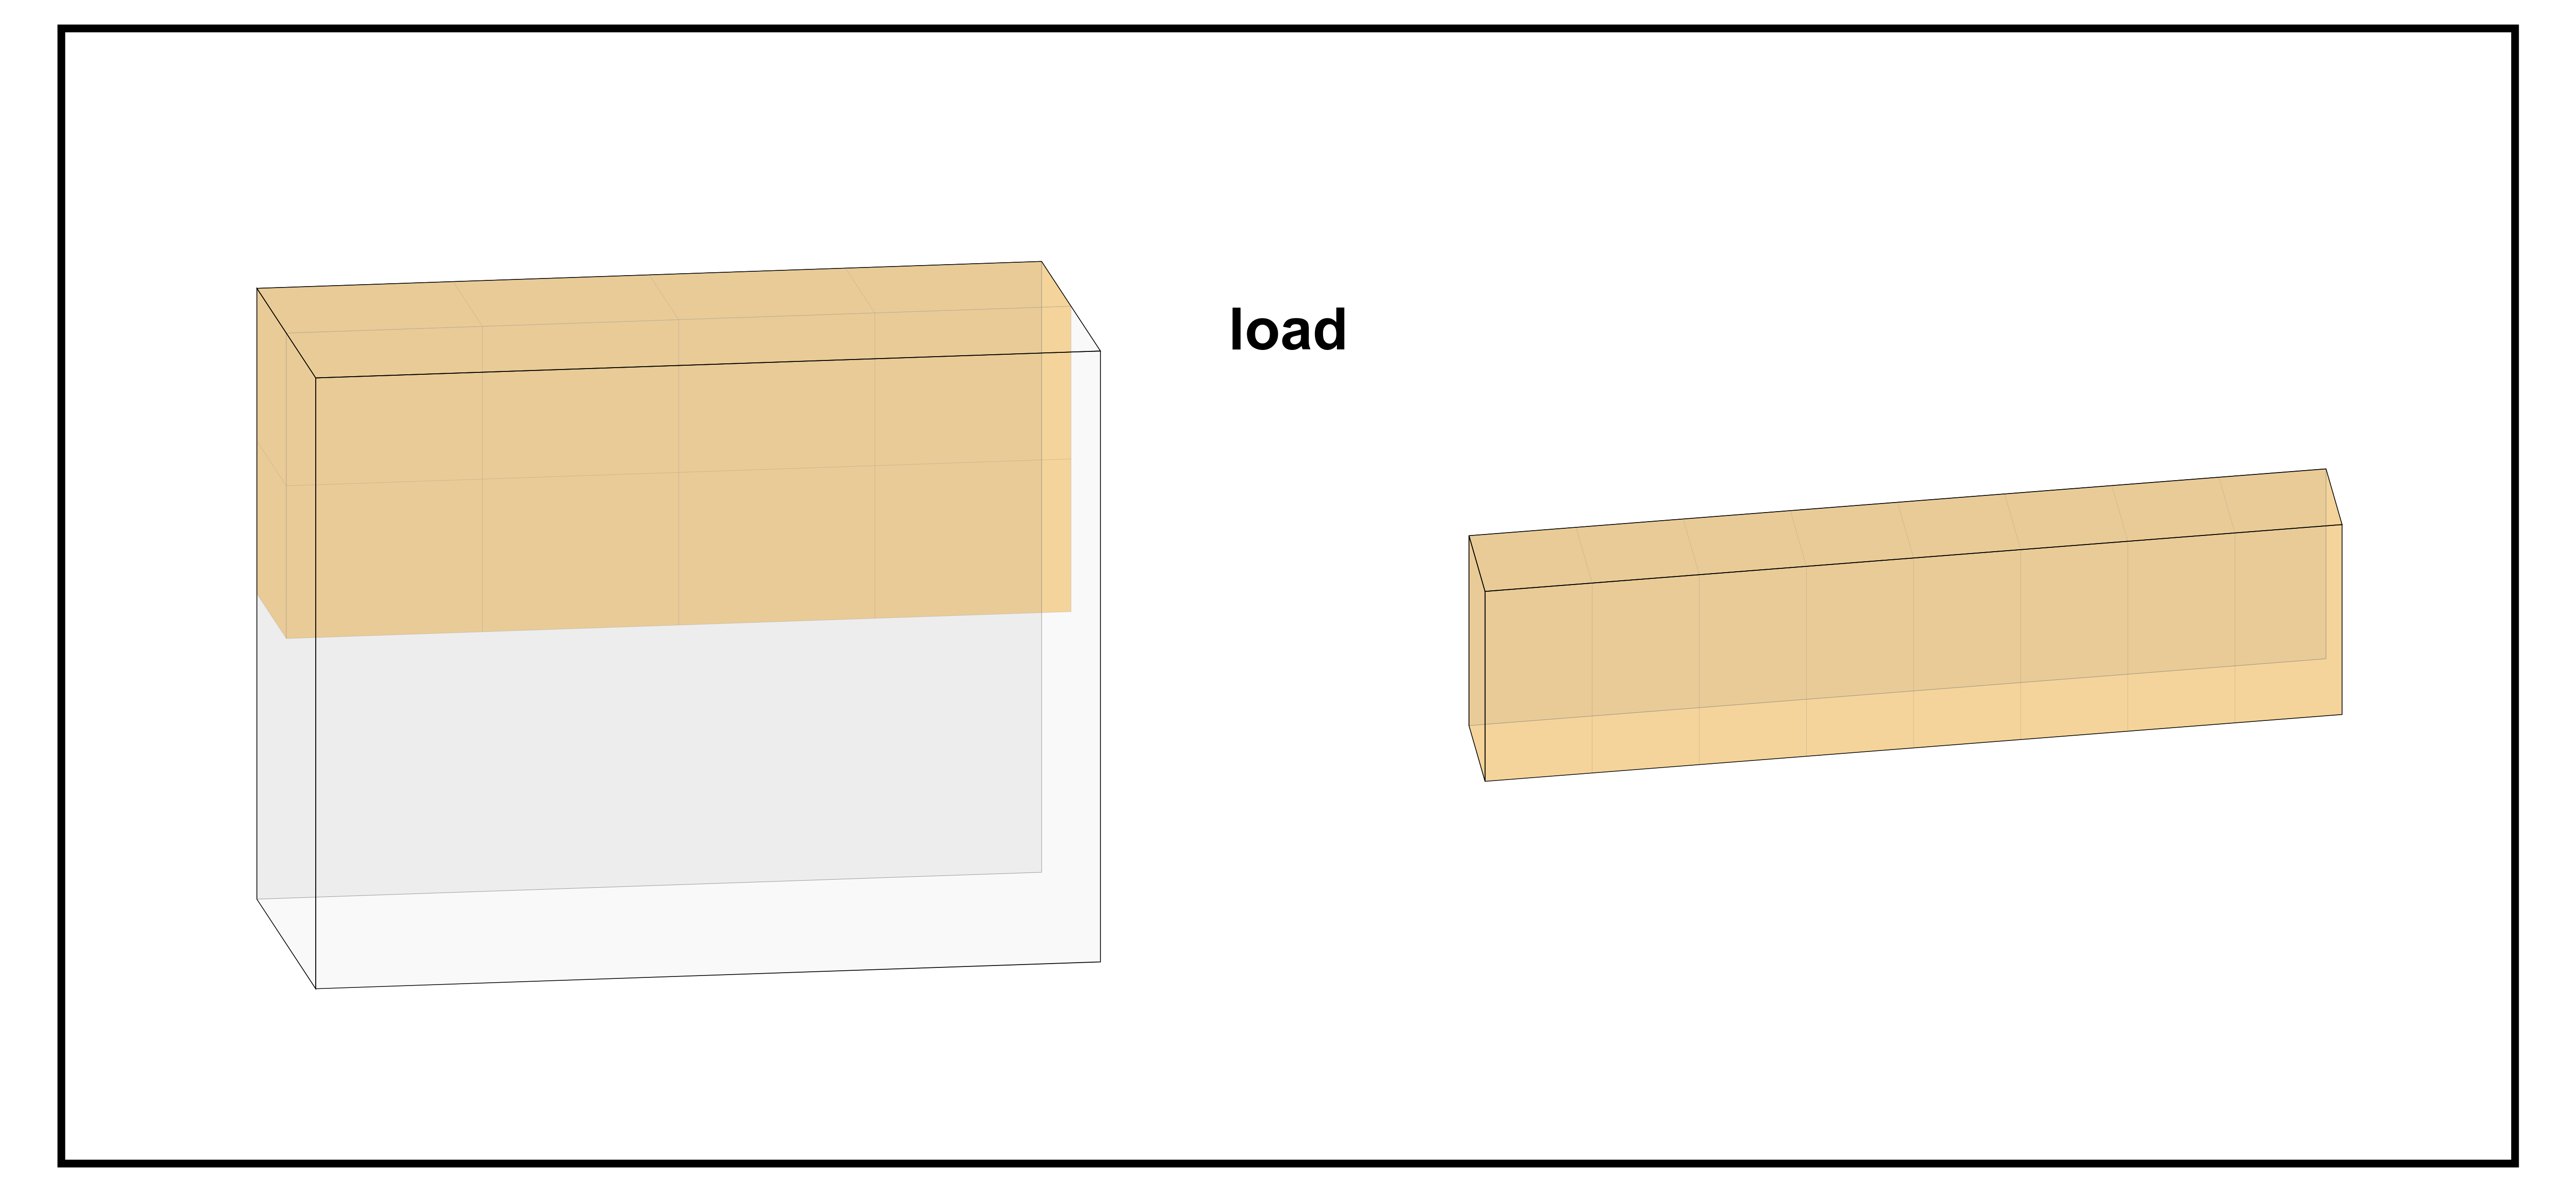

Coding for Triton is very similar to Numpy and PyTorch in both syntax and semantics. However, as a lower-level language there are a lot of details that you need to keep track of. In particular, one area that learners have trouble with is memory loading and storage which is critical for speed on low-level devices.

This set is puzzles is meant to teach you how to use Triton from first principles in an interactive fashion. You will start with trivial examples and build your way up to real algorithms like Flash Attention and Quantized neural networks. These puzzles **do not** need to run on GPU since they use a Triton interpreter.




In [1]:
%%capture
# Only need to run the first time.
# Works with latest triton. Sorry, this takes a minute to install.
!pip install jaxtyping
!pip install git+https://github.com/Deep-Learning-Profiling-Tools/triton-viz@v1
!wget "https://dl.cloudsmith.io/public/test-wha/triton-puzzles/raw/files/triton-3.0.0-cp310-cp310-linux_x86_64.whl"
!mv triton-3.0.0*.whl triton-3.0.0-cp310-cp310-linux_x86_64.whl
!pip install triton-3.0.0-cp310-cp310-linux_x86_64.whl
!export LC_ALL="en_US.UTF-8"
!export LD_LIBRARY_PATH="/usr/lib64-nvidia"
!export LIBRARY_PATH="/usr/local/cuda/lib64/stubs"
!ldconfig /usr/lib64-nvidia


In [2]:
import torch
import triton
from torch import Tensor
import triton.language as tl
import jaxtyping
from jaxtyping import Float32, Int32

## Introduction

To begin with, we will only use `tl.load` and `tl.store` in order to build simple programs.

Here's an example of load. It takes an `arange` over the memory. By default the indexing of torch tensors with column, rows, depths or right-to-left. It also takes in a mask as the second argument. Mask is critically important because all shapes in Triton need to be powers of two.

In [3]:
import triton_viz
import inspect
from triton_viz.interpreter import record_builder

@triton.jit
def demo(x_ptr):
    range = tl.arange(0, 8)
    # print works in the interpreter
    print(range)
    x = tl.load(x_ptr + range, range < 5, 0)
    print(x)
    y = tl.rand(1, range)
    print (y)

M = 15
N = 15
stride_cm = N
stride_cn = 1
BLOCK_SIZE_M = 4
BLOCK_SIZE_N = 4
GROUP_SIZE_M = 7

@triton.jit
def demo1(x_ptr):
    # Program ID
    pid = tl.program_id(axis=0)
    # Number of program ids along the M axis
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    # Number of programs ids along the N axis
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    # Number of programs in group
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    # Id of the group this program is in
    group_id = pid // num_pid_in_group
    # Row-id of the first program in the group
    first_pid_m = group_id * GROUP_SIZE_M
    # If `num_pid_m` isn't divisible by `GROUP_SIZE_M`, the last group is smaller
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    # *Within groups*, programs are ordered in a column-major order
    # Row-id of the program in the *launch grid*
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    # Col-id of the program in the *launch grid*
    pid_n = (pid % num_pid_in_group) // group_size_m

    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    x_ptrs = x_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    x_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    x = tl.load(x_ptrs, x_mask)

    print("Print for each", pid,  x)



torch.manual_seed(0)

tt_args = torch.rand(M, N)

grid = lambda meta: (4, 1, 1)

#triton_viz.trace(demo)[(1, 1, 1)](torch.ones(4, 3))
#triton_viz.trace(demo1)[(8, 1, 1)](torch.ones(1023, 1023))
triton_viz.trace(demo1)[grid](tt_args, )
triton_viz.launch()

Print for each [0] [[0.4962566  0.7682218  0.08847743 0.13203049]
 [0.5185218  0.6976676  0.8000114  0.16102946]
 [0.30510002 0.9320004  0.17591017 0.26983356]
 [0.242235   0.81546897 0.7931606  0.27825248]]
Print for each [1] [[0.7262365  0.7010802  0.20382375 0.65105355]
 [0.9411784  0.5995073  0.06520867 0.54599625]
 [0.68329567 0.75285405 0.8579358  0.6869556 ]
 [0.49101293 0.12347054 0.11432165 0.4724502 ]]
Print for each [2] [[0.69621414 0.5299501  0.25603563 0.7365945 ]
 [0.44859987 0.5138961  0.45686555 0.6011907 ]
 [0.03207397 0.0779959  0.39858162 0.774203  ]
 [0.5064661  0.27286255 0.6883496  0.04997081]]
Print for each [3] [[0.55365247 0.39531565 0.8570563  0.63957226]
 [0.22475791 0.20864725 0.6708725  0.20204341]
 [0.496278   0.40115923 0.5627332  0.38582766]
 [1.         1.         1.         1.        ]]
Running on public URL: https://d02cbd3300ac9c7bd7.gradio.live


{}